In [158]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline
# helper functions

import yfinance as yf
from hmmlearn.hmm import GaussianHMM
import plotly.express as px

def calculate_monthly_state_classification(dates, num_states):
    sp500 = yf.download('^GSPC','1999-01-01','2022-04-01')
    log_returns = np.log(sp500["Open"]/sp500["Open"].shift(1)).dropna()
    training_mask = log_returns.index < BEGINNING_OF_TEST_PERIOD
    training_returns = log_returns.loc[training_mask]
    training_returns_arr = training_returns.values.reshape(-1,1)
    log_returns_arr = log_returns.values.reshape(-1,1)
    model = GaussianHMM(n_components=num_states, covariance_type="diag", n_iter=1000).fit(training_returns_arr)
    hidden_states = model.predict(log_returns_arr)
    print("-----Fitted Market Regimes For ",num_states)
    for i in range(model.n_components):
        print("{0}th hidden state".format(i))
        print("mean = ", model.means_[i])
        print("var = ", np.diag(model.covars_[i]))

    states = []
    for d in dates:
        idx = log_returns.index.get_loc(d, method='ffill')
        state = hidden_states[idx]
        states.append(state)
    print("!")
    ans = pd.DataFrame(states, index = dates, columns = ["state"])
    return ans

def plot_states_over_time(states, num_states):
    fig = go.Figure()
    for i in range(num_states):
        state_mask = (states["state"] == i)
        states_copy = states.copy()
        states_copy[~state_mask] = 0
        states_copy[state_mask] = 1
        states_copy = states_copy.values.squeeze()
        fig.add_trace(
            go.Bar(x=states.index, y=states_copy, name="State "+str(i), offsetgroup = 0, opacity = 0.5)
        )
                
    fig.update_layout(
        title_text="Market Regimes"
    )
    fig.update_xaxes(title_text="Date")
    fig.show()


def calculate_rolling_ann_sd(prev_returns, com):
    emw_returns = prev_returns.ewm(com=com, min_periods=0, adjust=True).mean()
    observed_var = np.power(prev_returns - emw_returns, 2)
    rolling_ann_var = 12 * observed_var.ewm(com=com, min_periods=10, adjust=True).mean()
    rolling_ann_sd = np.power(rolling_ann_var, 0.5)
    return rolling_ann_sd

def calculate_XSM_position(prev_returns, num_stocks):
    ranks = prev_returns.rank(axis = 1, method="first")
    num_elements = ranks.max(axis = 1)
    ranks_sub = ranks.sub(num_elements, axis = 0)
    to_long = (ranks_sub > -num_stocks)*1
    to_short = (ranks <= num_stocks) *1*0
    position = (to_long-to_short)
    return position

def calculate_TSM_position(prev_returns, num_stocks):
    positions = prev_returns
    positions[positions < 0] = 0
    return positions

def calculate_BAH_strat(prev_returns):
    to_long = prev_returns.copy()
    to_long = prev_returns.fillna(0)
    to_long[to_long != 0] = 1
    return to_long

def calculate_MACD(prev_returns):
    price = prev_returns.cumprod()
    exp1 = price.ewm(span = 2, adjust = False).mean()
    exp2 = price.ewm(span = 5, adjust = False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span = 2, adjust = False).mean()
    signal[signal<0]=0
    return signal

def calculate_hmm_strat(strategies, prev_returns_full, hmm_states, n_states, plot_hist = False, allow_anti_strats = False):
    # for each strat, calculate avg return in different states. Create matrix. Plot histogram of return and abs return. 
    # map states to strat. Construct new position table. 
    prev_returns = prev_returns_full.loc[prev_returns_full.index< BEGINNING_OF_TEST_PERIOD]
    return_means_dict = {}
    for strat in strategies:
        truncated_strat = strategies[strat].loc[strategies[strat].index < BEGINNING_OF_TEST_PERIOD]
        combined_prev_rets = calculate_strategy_performance(prev_returns, truncated_strat, return_all_data = False)
        log_prev_rets = np.log(combined_prev_rets+1)
        return_means = []
        for i in range(n_states):
            state_mask = (hmm_states == i)
            #if we are in state i in time x, we add the return we would get from the strategy at time (x->x+1), which is log_prev_rets[x+1] 
            return_mean = (log_prev_rets.shift(-1).loc[state_mask["state"]]).mean(axis=0)
            return_means.append(return_mean)
        return_means_dict[strat] = return_means
    result_table = pd.DataFrame.from_dict(return_means_dict, orient="index", columns=[str(i) for i in range(n_states)])
    fig = px.imshow(result_table)
    fig.show()
    print(result_table)
    plot_states_over_time(hmm_states,n_states)
    #for each state (column), rank best
    if allow_anti_strats:
        mapping = np.abs(result_table).idxmax(axis = 0)
        mapping = mapping.fillna("BAH")
        for i in range(n_states):
            choice = mapping.loc[str(i)]
            result_avg_return = result_table[str(i)].loc[choice]
            if result_avg_return < 0:
                mapping.loc[str(i)]= "ANTI-"+mapping.loc[str(i)]
    else:
        mapping = result_table.idxmax(axis = 0) 
        mapping = mapping.fillna("BAH")
    print(mapping)
    
    final_strat = strategies["BAH"].copy()
    for i in range(n_states):
        choice = mapping.loc[str(i)]
        choice_key = choice
        is_anti = False
        if choice_key.startswith("ANTI-"):
            is_anti = True
            choice_key = choice_key[5:]
        pos_mult = 1
        if is_anti:
            pos_mult = -1
        state_mask = (hmm_states == i)
        final_strat.loc[state_mask["state"]] = strategies[choice_key].loc[state_mask["state"]] * pos_mult
    return final_strat

def calculate_combined_position(positions, long_exposure = 1, short_exposure = 0.25):
    long_mask = positions > 0
    short_mask = positions < 0
    long_positions_normalized = positions.copy()
    long_positions_normalized[short_mask] = 0
    long_positions_normalized = long_positions_normalized.div(long_positions_normalized.sum(axis = 1), axis = 0).fillna(0) * long_exposure
    short_positions_normalized = positions.copy()
    short_positions_normalized[long_mask] = 0
    short_positions_normalized = short_positions_normalized.div(np.abs(short_positions_normalized.sum(axis = 1)), axis = 0).fillna(0) * short_exposure
    combined_positions = long_positions_normalized+short_positions_normalized
    return combined_positions
    
def calculate_strategy_performance(prev_returns, positions, return_all_data = True):
    # prev_strat_profit_return.iloc[date] = return made via position at (date-1)
    combined_positions = calculate_combined_position(positions)
    #
    strat_prev_profit_return = positions.shift(1) * prev_returns
    combined_prev_profit_return = (combined_positions.shift(1) * prev_returns).sum(axis=1)
    strat_prev_profit_return["combined"] = combined_prev_profit_return
    # calculate strategy value
    strategy_value = (strat_prev_profit_return+1).cumprod(skipna = True, axis = 0)#.ffill(axis=0)
    # calculate sharpe
    n_years_traded = strat_prev_profit_return.count(axis = 0)/12
    sharpe = (strategy_value.iloc[-1].pow(1/n_years_traded) - 1)/(strat_prev_profit_return.std() * np.sqrt(12))
    #calculate drawdown
    max_strategy_value = strategy_value.cummax()  #max previous cumret
    drawdown_pct = 1 - strategy_value/max_strategy_value   #all drawdowns
    max_drawdown = drawdown_pct.max(axis = 0)
    # return values
    if return_all_data:
        return strat_prev_profit_return["combined"], strategy_value["combined"], max_drawdown["combined"], sharpe["combined"]
    else:
        return strat_prev_profit_return["combined"]
    
def plot_strategy_performances(prev_returns, dict_strategy_positions, states,num_states, time_index):
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    prev_returns = prev_returns.loc[time_index]
    states = states.loc[time_index]
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                    subplot_titles=["Strategy Value", "HMM State"])
    
    for strategy_name in dict_strategy_positions:
        prev_strat_profit_return, strategy_value, max_drawdown, sharpe = calculate_strategy_performance(prev_returns,dict_strategy_positions[strategy_name].loc[time_index])
        fig.add_trace(
            go.Scatter(
                x=time_index, y=strategy_value.loc[time_index], name=strategy_name
            ), row=1,col=1
        )
        print(strategy_name)
        print("Sharpe:",sharpe)
        print("Max Drawdown:", max_drawdown)
    
    for i in range(num_states):
        state_mask = (states["state"] == i)
        states_copy = states.copy()
        states_copy[~state_mask] = 0
        states_copy[state_mask] = 1
        states_copy = states_copy.values.squeeze()
        fig.add_trace(
            go.Bar(x=states.index, y=states_copy, name="State "+str(i), offsetgroup = 0, opacity = 0.5), row=2,col=1
        )
                
    fig.update_xaxes(title_text="Date")
    fig.show()

        
BEGINNING_OF_TEST_PERIOD = pd.to_datetime("2015-01")
# setup data
def setup_data():
    import os
    working_path = os.getcwd()
    root_index_key = "ArbitrageFactory"
    root_index = working_path.find(root_index_key)
    os.chdir(working_path[:(root_index+len(root_index_key))])
    working_path = os.getcwd()
    #print("Working directory is: "+working_path)
    FX_data = pd.read_csv("FXData/FXData.csv")
    #print(FX_data.columns)
    def preprocess_fx_data(data):
        dataframes = {"open_price": [], "debt_assets" : [], "de_ratio" : [], "CPI" : [], "Unemployment" : [], "volume" : [], "prev_return" : [] }
        keys = []
        for name, group in data.groupby('PERMNO'):
            keys.append(name)
            group = group.copy()
            group.index = group["month"]
            group.sort_index(axis = 0, inplace = True)
            group["return_1M"].fillna(0,inplace = True)
            #print(group["return_1M"].index)
            dataframes["open_price"].append((group["return_1M"]+1).cumprod(skipna = True, axis = 0))
            dataframes["debt_assets"].append(group["debt_assets"])
            dataframes["de_ratio"].append(group["de_ratio"])
            dataframes["CPI"].append(group["CPI"])
            dataframes["Unemployment"].append(group["Unemployment"])
            dataframes["volume"].append(group["volume"])
            dataframes["prev_return"].append(group["return_1M"])
        for key in dataframes:
            dataframes[key] = pd.concat(dataframes[key], axis = 1, keys = keys)
            dataframes[key].index = pd.to_datetime(dataframes[key].index)
        # compute additional data
        dataframes["prev_log_return"] = np.log(dataframes["prev_return"]+1)
        dataframes["sd_fast"] = calculate_rolling_ann_sd(dataframes["prev_return"],10)
        dataframes["sd_slow"] = calculate_rolling_ann_sd(dataframes["prev_return"],40)
        dataframes["sd_fast/slow"] = (dataframes["sd_fast"]/dataframes["sd_slow"]).clip(lower = 0, upper = 2)
        dataframes["norm_de_ratio"] = dataframes["de_ratio"].clip(lower = 0, upper = 5)/5
        
        dataframes["strats"] = {}
        
        dataframes["strats"]["BAH"] = calculate_BAH_strat(dataframes["prev_return"])
        
        dataframes["strats"]["EXIT"] = (dataframes["strats"]["BAH"].copy())
        dataframes["strats"]["EXIT"][dataframes["strats"]["EXIT"]<100] = 0
        
        for num_stocks in [2,10]:
            for lookback in [1,24]:
                strat_name = "BUYTOP_"+str(num_stocks)+"_"+str(lookback)
                lookback_returns = dataframes["open_price"]/dataframes["open_price"].shift(lookback)-1
                dataframes["strats"][strat_name] = calculate_XSM_position(lookback_returns, num_stocks)
        
        #for lookback in [1,12,24]:
        #    strat_name = "TSM_"+str(lookback)
        #    lookback_returns = dataframes["open_price"]/dataframes["open_price"].shift(lookback)-1
        #    dataframes["strats"][strat_name] = calculate_TSM_position(lookback_returns, lookback)
        
        for num_states in [2]:
            dataframes["hmm_states_"+str(num_states)] = calculate_monthly_state_classification(dataframes["open_price"].index,num_states)
        
        #dataframes["strats"]["MACD"] = calculate_MACD(dataframes["prev_return"])
        hmm_strats = {}
        for n_states in [2]:
            print("---computing strats for n-states=",n_states)
            hmm_strats["HMM_"+str(n_states)] = calculate_hmm_strat(dataframes["strats"], dataframes["prev_return"], dataframes["hmm_states_"+str(n_states)], n_states, allow_anti_strats = False)
            #hmm_strats["HMM_ANTI_"+str(n_states)] = calculate_hmm_strat(dataframes["strats"], dataframes["prev_return"], dataframes["hmm_states_"+str(n_states)], n_states, allow_anti_strats = True)
        for strat_name in hmm_strats:
            dataframes["strats"][strat_name] = hmm_strats[strat_name]
        return dataframes
    return preprocess_fx_data(FX_data)
dataframes = setup_data()

#Plot hidden state as separate axis under perf. Filter strats and make story. 
#Create final strat.
#Tex. 


[*********************100%***********************]  1 of 1 completed
-----Fitted Market Regimes For  2
0th hidden state
mean =  [0.00055384]
var =  [6.3304813e-05]
1th hidden state
mean =  [-0.00089452]
var =  [0.00038374]
!
---computing strats for n-states= 2


                     0         1
BAH           0.008071  0.005537
EXIT          0.000000  0.000000
BUYTOP_2_1    0.005054  0.002317
BUYTOP_2_24   0.012772 -0.004297
BUYTOP_10_1   0.006281  0.011158
BUYTOP_10_24  0.015514 -0.006576


0    BUYTOP_10_24
1     BUYTOP_10_1
dtype: object


In [162]:

#Visual inspection of state, strategy perfs, for set time period
cutoff_index = dataframes["prev_return"].index.get_loc(BEGINNING_OF_TEST_PERIOD)
train_index = dataframes["prev_return"].index[:cutoff_index]
test_index = dataframes["prev_return"].index[cutoff_index:]

plot_strategy_performances(dataframes["prev_return"], dataframes["strats"], dataframes["hmm_states_2"],2, train_index)


#plot_states_over_time(dataframes["hmm_states_5"], 5)

BAH
Sharpe: 0.5189855060843608
Max Drawdown: 0.5432873889468466
EXIT
Sharpe: nan
Max Drawdown: 0.0
BUYTOP_2_1
Sharpe: 0.14304270783917683
Max Drawdown: 0.7512937408342603
BUYTOP_2_24
Sharpe: 0.4161338277208132
Max Drawdown: 0.544770301347889
BUYTOP_10_1
Sharpe: 0.3420240369473622
Max Drawdown: 0.5883168144332107
BUYTOP_10_24
Sharpe: 0.6520043173343009
Max Drawdown: 0.5349314323417594
HMM_2
Sharpe: 0.7120044714125048
Max Drawdown: 0.5242924307752423


In [164]:
dataframes["strats"]["HMM_2"].to_csv("HMM_strat_positions.csv")
dataframes["hmm_states_2"].to_csv("HMM_States.csv")

10225.0 79637.0


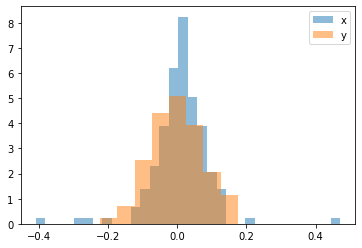

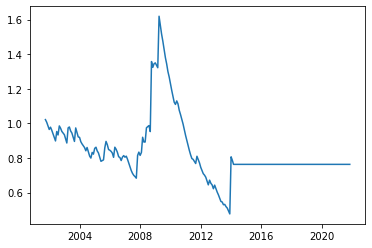

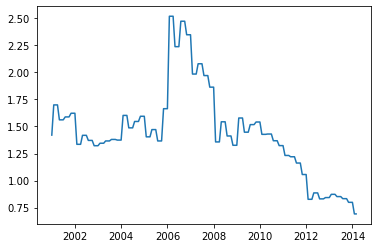

50-50
Sharpe: -0.27588577824617383
Max Drawdown: 0.7447515632166558
Buy Index
Sharpe: 0.585876971102163
Max Drawdown: 0.5432873889468466


In [3]:
from matplotlib import pyplot as plt
# visually inspect log returns, sd_fast/sd_slow
def plot_hist_comparison(data_x,data_y):
    import random
    plt.hist(data_x, bins="auto", alpha=0.5, label='x', density = True)
    plt.hist(data_y, bins="auto", alpha=0.5, label='y', density = True)
    plt.legend(loc='upper right')
    plt.show()
N = len(dataframes["prev_log_return"].columns)
choice_x = dataframes["prev_log_return"].columns[np.random.randint(low=0,high=N)]
choice_y = dataframes["prev_log_return"].columns[np.random.randint(low=0,high=N)]
print(choice_x,choice_y)
plot_hist_comparison(dataframes["prev_log_return"][choice_x].dropna(),dataframes["prev_log_return"][choice_y].dropna())
graph_data = dataframes["sd_fast/slow"][choice_x].dropna()
plt.plot(graph_data.index, graph_data)
plt.show()
graph_data = dataframes["de_ratio"][choice_x].dropna()
plt.plot(graph_data.index, graph_data)
plt.show()

plot_strategy_performances(dataframes["prev_return"], {"50-50" : dataframes["baseline_50_50_position"], "Buy Index": dataframes["baseline_BAH_position"]})


# Attempts at using Pyro for Markov Model with side information

In [25]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def simple_hmm(return_sequences, 
               lengths, 
               num_hidden_states, 
               batch_size=None):
    assert not torch._C._get_tracing_state()
    num_sequences, max_length = return_sequences.shape
    
    transition_probs = pyro.param(
        "transition_matrix",
        lambda: torch.ones((num_hidden_states,num_hidden_states))
    )
        
    return_means = pyro.param(
        "return_means",
        lambda: torch.zeros((num_hidden_states,)),
    )
    return_vars = pyro.param(
        "return_vars",
        lambda: 0.1*torch.ones((num_hidden_states,)),
        constraint=constraints.positive
    )
    # In this first model we'll sequentially iterate over sequences in a
    # minibatch; this will make it easy to reason about tensor shapes.
    for i in pyro.plate("return_sequences", num_sequences, batch_size):
        print(i)
        length = lengths[i]
        sequence = return_sequences[i, :length]
        x = 0
        for t in pyro.markov(range(length)):
            # On the next line, we'll overwrite the value of x with an updated
            # value. If we wanted to record all x values, we could instead
            # write x[t] = pyro.sample(...x[t-1]...).
            x = pyro.sample(
                "x_{}_{}".format(i, t),
                dist.Categorical(logits=transition_probs[x]),
                infer={"enumerate": "parallel"},
            )
            r = pyro.sample(
                "r_{}_{}".format(i, t),
                dist.Normal(return_means[x],return_vars[x]),
                obs=sequence[t]
            )

#fake_data = np.random.normal(size=(100,50))
#fake_lengths = np.array([50]*100)
simple_hmm(fake_data,fake_lengths,2,5)
def compute_hmm_strat():
    pyro.set_rng_seed(1)
    pyro.clear_param_store()
    model = simple_hmm
    guide = AutoDelta(
        poutine.block(model, expose_fn=lambda msg: msg["name"].startswith("probs_"))
    )
    lr = 0
    num_training_steps = 50
    num_hidden_states = 2
    
    optim = Adam({"lr": lr})
    Elbo = TraceEnum_ELBO
    elbo = Elbo(
        max_plate_nesting=1,
        strict_enumeration_warning=True,
        jit_options={"time_compilation": args.time_compilation},
    )
    svi = SVI(model, guide, optim, elbo)
    for step in range(num_training_steps):
        loss = svi.step(return_sequences, lengths, num_hidden_states, batch_size=10)
        print(step, loss / num_observations)
        logging.info("{: >5d}\t{}".format(step, loss / num_observations))
        
    train_loss = elbo.loss(model, guide, sequences, lengths, args, include_prior=False)
    logging.info("training loss = {}".format(train_loss / num_observations))

    # Finally we evaluate on the test dataset.
    logging.info("-" * 40)
    logging.info(
        "Evaluating on {} test sequences".format(len(data["test"]["sequences"]))
    )
    sequences = data["test"]["sequences"][..., present_notes]
    lengths = data["test"]["sequence_lengths"]
    if args.truncate:
        lengths = lengths.clamp(max=args.truncate)
    num_observations = float(lengths.sum())

    # note that since we removed unseen notes above (to make the problem a bit easier and for
    # numerical stability) this test loss may not be directly comparable to numbers
    # reported on this dataset elsewhere.
    test_loss = elbo.loss(
        model, guide, sequences, lengths, args=args, include_prior=False
    )
    logging.info("test loss = {}".format(test_loss / num_observations))

    # We expect models with higher capacity to perform better,
    # but eventually overfit to the training set.
    capacity = sum(
        value.reshape(-1).size(0) for value in pyro.get_param_store().values()
    )
    logging.info("{} capacity = {} parameters".format(model.__name__, capacity))


In [26]:
models = {"simple_hmm": simple_hmm}


def fit_simple_hmm(args):
    if args.cuda:
        torch.set_default_tensor_type("torch.cuda.FloatTensor")

    logging.info("Loading data")
    data = poly.load_data(poly.JSB_CHORALES)

    logging.info("-" * 40)
    model = models[args.model]
    logging.info(
        "Training {} on {} sequences".format(
            model.__name__, len(data["train"]["sequences"])
        )
    )
    sequences = data["train"]["sequences"]
    lengths = data["train"]["sequence_lengths"]

    # find all the notes that are present at least once in the training set
    present_notes = (sequences == 1).sum(0).sum(0) > 0
    # remove notes that are never played (we remove 37/88 notes)
    sequences = sequences[..., present_notes]

    if args.truncate:
        lengths = lengths.clamp(max=args.truncate)
        sequences = sequences[:, : args.truncate]
    num_observations = float(lengths.sum())
    pyro.set_rng_seed(args.seed)
    pyro.clear_param_store()

    # We'll train using MAP Baum-Welch, i.e. MAP estimation while marginalizing
    # out the hidden state x. This is accomplished via an automatic guide that
    # learns point estimates of all of our conditional probability tables,
    # named probs_*.
    guide = AutoDelta(
        poutine.block(model, expose_fn=lambda msg: msg["name"].startswith("probs_"))
    )

    # To help debug our tensor shapes, let's print the shape of each site's
    # distribution, value, and log_prob tensor. Note this information is
    # automatically printed on most errors inside SVI.
    if args.print_shapes:
        first_available_dim = -2
        guide_trace = poutine.trace(guide).get_trace(
            sequences, lengths, args=args, batch_size=args.batch_size
        )
        model_trace = poutine.trace(
            poutine.replay(poutine.enum(model, first_available_dim), guide_trace)
        ).get_trace(sequences, lengths, args=args, batch_size=args.batch_size)
        logging.info(model_trace.format_shapes())

    # Enumeration requires a TraceEnum elbo and declaring the max_plate_nesting.
    # All of our models have two plates: "data" and "tones".
    optim = Adam({"lr": args.learning_rate})
    if args.tmc:
        if args.jit:
            raise NotImplementedError("jit support not yet added for TraceTMC_ELBO")
        elbo = TraceTMC_ELBO(max_plate_nesting=1)
        tmc_model = poutine.infer_config(
            model,
            lambda msg: {"num_samples": args.tmc_num_samples, "expand": False}
            if msg["infer"].get("enumerate", None) == "parallel"
            else {},
        )  # noqa: E501
        svi = SVI(tmc_model, guide, optim, elbo)
    else:
        Elbo = JitTraceEnum_ELBO if args.jit else TraceEnum_ELBO
        elbo = Elbo(
            max_plate_nesting=1,
            strict_enumeration_warning=True,
            jit_options={"time_compilation": args.time_compilation},
        )
        svi = SVI(model, guide, optim, elbo)

    # We'll train on small minibatches.
    logging.info("Step\tLoss")
    for step in range(args.num_steps):
        loss = svi.step(sequences, lengths, args=args, batch_size=args.batch_size)
        logging.info("{: >5d}\t{}".format(step, loss / num_observations))

    if args.jit and args.time_compilation:
        logging.debug(
            "time to compile: {} s.".format(elbo._differentiable_loss.compile_time)
        )

    # We evaluate on the entire training dataset,
    # excluding the prior term so our results are comparable across models.
    train_loss = elbo.loss(model, guide, sequences, lengths, args, include_prior=False)
    logging.info("training loss = {}".format(train_loss / num_observations))

    # Finally we evaluate on the test dataset.
    logging.info("-" * 40)
    logging.info(
        "Evaluating on {} test sequences".format(len(data["test"]["sequences"]))
    )
    sequences = data["test"]["sequences"][..., present_notes]
    lengths = data["test"]["sequence_lengths"]
    if args.truncate:
        lengths = lengths.clamp(max=args.truncate)
    num_observations = float(lengths.sum())

    # note that since we removed unseen notes above (to make the problem a bit easier and for
    # numerical stability) this test loss may not be directly comparable to numbers
    # reported on this dataset elsewhere.
    test_loss = elbo.loss(
        model, guide, sequences, lengths, args=args, include_prior=False
    )
    logging.info("test loss = {}".format(test_loss / num_observations))

    # We expect models with higher capacity to perform better,
    # but eventually overfit to the training set.
    capacity = sum(
        value.reshape(-1).size(0) for value in pyro.get_param_store().values()
    )
    logging.info("{} capacity = {} parameters".format(model.__name__, capacity))
    
def fit_simple_hmm_main():
    parser = argparse.ArgumentParser(
        description="MAP Baum-Welch learning Bach Chorales"
    )
    parser.add_argument(
        "-m",
        "--model",
        default="simple_hmm",
        type=str,
        help="one of: {}".format(", ".join(sorted(models.keys()))),
    )
    parser.add_argument("-n", "--num-steps", default=50, type=int)
    parser.add_argument("-b", "--batch-size", default=8, type=int)
    parser.add_argument("-d", "--hidden-dim", default=16, type=int)
    parser.add_argument("-nn", "--nn-dim", default=48, type=int)
    parser.add_argument("-nc", "--nn-channels", default=2, type=int)
    parser.add_argument("-lr", "--learning-rate", default=0.05, type=float)
    parser.add_argument("-t", "--truncate", type=int)
    parser.add_argument("-p", "--print-shapes", action="store_true")
    parser.add_argument("--seed", default=0, type=int)
    parser.add_argument("--cuda", action="store_true")
    parser.add_argument("--jit", action="store_true")
    parser.add_argument("--time-compilation", action="store_true")
    parser.add_argument("-rp", "--raftery-parameterization", action="store_true")
    parser.add_argument(
        "--tmc",
        action="store_true",
        help="Use Tensor Monte Carlo instead of exact enumeration "
        "to estimate the marginal likelihood. You probably don't want to do this, "
        "except to see that TMC makes Monte Carlo gradient estimation feasible "
        "even with very large numbers of non-reparametrized variables.",
    )
    parser.add_argument("--tmc-num-samples", default=10, type=int)
    args = parser.parse_known_args()
    fit_simple_hmm(args[0])
fit_simple_hmm_main()

  4166177 Loading data
  4166247 ----------------------------------------
  4166248 Training simple_hmm on 229 sequences
  4166271 Step	Loss
  4167322     0	48.117553596002026
  4168366     1	48.74950206417035
  4169366     2	41.96953538060404
  4170009     3	29.518072807271675
  4170963     4	35.31023439197509
  4171842     5	33.92618327659883
  4172764     6	31.70344073658289
  4173760     7	30.699328239298907
  4174722     8	30.16684471644818
  4175605     9	23.837994314478163
  4176328    10	20.103160987180416
  4177454    11	26.01041817556312
  4178435    12	20.04948576808865
  4179169    13	14.759218602882596
  4180170    14	16.288379535742738
  4181321    15	15.124800825668139
  4182233    16	11.37163440646049
  4183205    17	8.71507263073079
  4184296    18	8.249758953791556
  4185428    19	5.843283185159701
  4186368    20	3.093192934290577
  4187493    21	1.0373511285036576
  4188587    22	-0.07667432867782194
  4189494    23	-1.6962216572662419
  4190471    24	-3.28554073567